# ```Elo Rating``` System #
 
### Documentation ###
- Kaggle Elo Rating Algorithm - [Link](https://www.kaggle.com/discussions/getting-started/216048);
- Wikipedia Elo Rating - [Link](https://en.wikipedia.org/wiki/Elo_rating_system);
- 538 Calculate NBA Elo - [Link](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/);
- Medium Elo Rating System - [Link](https://stanislav-stankovic.medium.com/elo-rating-system-6196cc59941e);

### Importing Dependencies ###

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

---

### Introduction ###
```Elo Rating``` is a method for calculating the relative skill levels of players/teams in zero-sum games, like chess. Players with higher Elo rating have a higher probability of winning a game than a player with lower one. After each game, players' ratings are updated. 

If a player with higher Elo rating wins, only a few points are transferred from the lower rated player, however if the lower rated player wins, then transferred points from a higher rated player are far greater.

The difference in rating between 2 players determines an estimate for the ```expected score``` between them.

### Components ###
There are mainly 3 main component of this rating system:

**Intial Ratings**: when starting, all players are assigned a ```default score``` (a baseline);

**Probability of Winning**: in a match between 2 players the probability (```P```) of winning depends exclusively on the ratings (```r```) of the players;

In [2]:
%%latex
\begin{align*}
    & P_{1} = \frac{r_{1}}{r_{1} + r_{2}} \\
    & P_{2} = \frac{r_{2}}{r_{1} + r_{2}}
\end{align*}

<IPython.core.display.Latex object>

**Rating Shifting Factor**: the factor (```K```; constant set by the user) by which rating's from lossing team to be shifted to wining team, after every game. In case team 1 wins:

In [3]:
%%latex
\begin{align*}
    & r_{1} = r_{1} + k(1 - P_{1}) \\
    & r_{2} = r_{2} + k(0 - P_{2}) \\
\end{align*}

<IPython.core.display.Latex object>

In case team 2 wins:

In [4]:
%%latex
\begin{align*}
    & r_{1} = r_{1} + k(0 - P_{1}) \\
    & r_{2} = r_{2} + k(1 - P_{2}) \\
\end{align*}

<IPython.core.display.Latex object>

### Expected Score ###
A player's ```expected score``` (```E```; ```expected outcome```) is their *probability of winning plus half their probability of drawing*. The probability of drawing, as opposed to having a decisive result, is not specified in the Elo system (instead, a draw is considered half a win and half a loss).

In [7]:
%%latex
\begin{align*}
    & E_{1} = \frac{1}{1 + 10^{(r_{2} - r_{1})/400}} \\
    & E_{2} = \frac{1}{1 + 10^{(r_{1} - r_{2})/400}} \\
    & E_{1} + E_{2} = 1
\end{align*}

<IPython.core.display.Latex object>

In our setup, for each ```400``` rating points of advantage over the opponent, the ```expected score``` is magnified 10x in comparison to the opponent's. When a player's actual tournament scores exceed/fall short their ```expected scores```, the Elo system takes this as evidence that player's rating is too low/high, and needs to be adjusted upward/downward.

### Main ###

In [163]:
# Reading the matches CSV
nfl_df = pd.read_csv("nfl_data.csv")
nfl_df.head(3)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,score1,score2
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.0,0.824651,0.175349,1516.108,1287.838,48,0
1,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688,1300.0,0.825267,0.174733,1516.803,1287.885,48,0
2,1920-10-03,1920,0,NaN,BFF,WBU,1478.004,1300.0,0.802000,0.198000,1489.757,1288.247,32,6


**Cleaning Data**

In [164]:
# Removing matches prior to 1995
nfl_df = nfl_df[nfl_df["season"] >= 2016] 
# Sorting based on 'date'
nfl_df.sort_values(by= "date", ascending= True, inplace= True)
# Reseting indexes
nfl_df.reset_index(drop= True, inplace= True)

In [165]:
# Renaming columns
nfl_df.rename(columns={"elo_prob1": "elo1_prob", "elo_prob2": "elo2_prob"}, inplace= True)

**User-Defined Functions**

In [166]:
def k_factor(victory_margin, elo_diff):
    # 'k': affects how quickly Elo adjusts to new game results
    # 'victory_margin': home_score - away_score
    #                   teams gain/lose more with larger margins of victory (via 'multiplier')
    # 'multiplier': based on final score divided by a team’s projected 'victory_margin', upon having won the game
    #               points won should be higher if 'victory_margin' is higher than Elo's expectation (with diminishing returns)
    init_k = 20 # Optimal 'k' for NFL (empirically)
                # Assumption: winning/losing streak is mostly skill (not luck)
                #             streaks reflect true (even temporary) changes in team quality
    if victory_margin > 0: # Home team wins
        multiplier = (victory_margin + 3) ** (0.8) / (7.5 + 0.006 * (elo_diff))
    else: # Away team wins
        multiplier = (-victory_margin + 3) ** (0.8) / (7.5 + 0.006 *(-elo_diff))
    return (init_k * multiplier, init_k * multiplier)

In [167]:
def actual_outcome(home_score, away_score):
    # 's_value': actual outcome of a match (1: win, 0.5: draw, 0: loss)
    #            values are    
    # Inital values
    s_home, s_away = 0, 0
    # Updating 's_value' based on match outcome
    if home_score > away_score: # Home team wins
        s_home = 1
    elif away_score > home_score: # Away team wins
        s_away = 1
    else: # Draw
        s_home, s_away = 0.5, 0.5
    return (s_home, s_away)

In [168]:
def expected_outcome(home_rating, away_rating):
    # 'c': constant scale factor (based on satisfying human perception); here we use 400
    return 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0))) # Expected outcome (E): maps the expectation of outcome onto the interval (0,1)

In [169]:
def elo_update(home_score, away_score, home_rating, away_rating, is_neutral, home_advantage= 100.0):
    # Checking for home advantage
    if not is_neutral:
        home_rating += home_advantage # 'home_advantage': bonus of 100 (could be higher depending on conditions, like altitute)
                                      #                   the number above should be calculated with historical avg points on home team wins (and ratings counterpart)
    # Updating params
    elo_home = expected_outcome(home_rating, away_rating)  
    elo_away = 1 - elo_home # E_home + E_away = 1
    elo_diff = home_rating - away_rating
    victory_margin = home_score	- away_score  
    # Updating 'actual_outcome' 
    s_home, s_away = actual_outcome(home_score, away_score)
    # Updating 'k_factor' (based on match result)
    if s_home > 0:
        k_home, k_away = k_factor(victory_margin, elo_diff)
    else:
        k_home, k_away = k_factor(victory_margin, elo_diff)
    return (k_home * (s_home - elo_home), k_away * (s_away - elo_away)) # Update factors on team's elo

**Calculating**

In [170]:
# Including blank calculation columns
nfl_df["calc_elo1_pre"] = ""
nfl_df["calc_elo2_pre"] = ""
nfl_df["calc_elo1_prob"] = ""
nfl_df["calc_elo2_prob"] = ""
nfl_df["calc_elo1_post"] = ""
nfl_df["calc_elo2_post"] = ""

In [171]:
# Finding the unique teams
unique_teams = nfl_df["team1"].unique()
# Creating dictionary with last elo
last_rating_dict = {}
for team in unique_teams:
    last_rating_dict[team] = [("2016-09-07", 1500)] # 1st element as day before season's debut

In [172]:
# Looping through all games 
for idx, game in nfl_df.iterrows(): 
    # Pulling parameters
    date = game["date"]
    home_score = game["score1"]
    away_score = game["score2"]
    home_rating = last_rating_dict[game["team1"]][-1][1] # Last tuple, 2nd item
    away_rating = last_rating_dict[game["team2"]][-1][1]
    home_prob = expected_outcome(home_rating, away_rating)
    away_prob = 1 - home_prob
    is_neutral = bool(game["neutral"])
    # Calculating rates increments/decrements
    home_elo, away_elo = elo_update(home_score, away_score, home_rating, away_rating, is_neutral)
    # Updating the DataFrame
    nfl_df.loc[idx, "calc_elo1_pre"] = home_rating
    nfl_df.loc[idx, "calc_elo2_pre"] = away_rating
    nfl_df.loc[idx, "calc_elo1_prob"] = home_prob
    nfl_df.loc[idx, "calc_elo2_prob"] = away_prob
    nfl_df.loc[idx, "calc_elo1_post"] = home_rating + home_elo
    nfl_df.loc[idx, "calc_elo2_post"] = away_rating + away_elo
    # Updating the dictionary
    last_rating_dict[game["team1"]].append((date, home_rating + home_elo))
    last_rating_dict[game["team2"]].append((date, away_rating + away_elo))

**Preparing Data**

In [194]:
## Superbowl 2017: New England x Atlanta Falcons (NE Champions)
# Creating NE and ATL DataFrames
ne_df = pd.DataFrame(last_rating_dict["NE"], columns= ["date", "elo_rating"])
atl_df = pd.DataFrame(last_rating_dict["ATL"], columns= ["date", "elo_rating"])
# Creating the dates DataFrame
dates_df = pd.DataFrame({"date": pd.date_range(start= "2016-09-07", end= nfl_df["date"].unique().max())})

In [195]:
# Casting all 'date' cols as 'datetime'
ne_df["date"] = pd.to_datetime(ne_df["date"], utc= True).dt.date
atl_df["date"] = pd.to_datetime(atl_df["date"], utc= True).dt.date
dates_df["date"] = pd.to_datetime(dates_df["date"], utc= True).dt.date

In [196]:
# Merging NE/ATL dfs with 'dates_df'
ne_df = pd.merge(dates_df, ne_df, how= "left", on= "date")
atl_df = pd.merge(dates_df, atl_df, how= "left", on= "date")

In [205]:
# Filling NaNs (forward) with previous available rating
ne_df.ffill(inplace= True)
atl_df.ffill(inplace= True)

**Plotting**

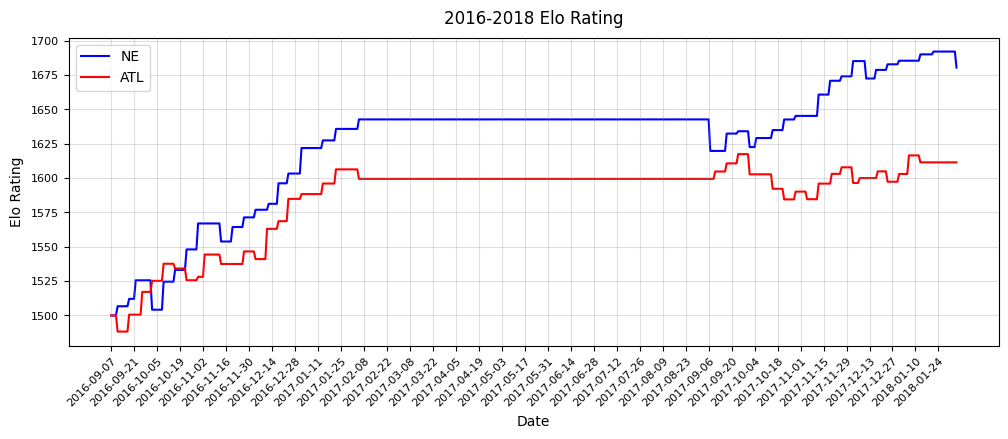

In [301]:
## Plotting 
fig, ax = plt.subplots(nrows= 1, ncols= 1, figsize= (12, 4))
ax.plot(ne_df["date"], ne_df["elo_rating"], linewidth= 1.5, color= "blue", label= "NE", zorder= 0)
ax.plot(atl_df["date"], atl_df["elo_rating"], linewidth= 1.5, color= "red", label= "ATL", zorder= 0)
# Labels
ax.set_xlabel("Date", fontname= "sans-serif", fontsize= 10, labelpad= 5) 
ax.set_ylabel("Elo Rating", fontname= "sans-serif", fontsize= 10, labelpad= 5)
# Ticks
ax.set_xticks(ne_df["date"][::14]) # Ticks every 2 weeks (reduce clutter)
ax.set_xticklabels(ne_df["date"][::14], rotation= 45, ha= "right", rotation_mode= "anchor")
ax.tick_params(axis= "both", which= "major", labelsize= 8)
# Title
ax.set_title("2016-2018 Elo Rating", loc= "center", fontsize= 12, fontname= "sans-serif", pad= 10) # Plot title
# Grid
ax.grid(which="both", color= "gray", alpha=0.25)
# Legend
ax.legend()

---